<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/ME697-advanced-scientific-machine-learning/blob/main/07_homework_work_in_progress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures

# Homework 7

## References

+ Module 5: Inverse problems in deterministic scientifc models
    - Purely data-driven learning of dynamical systems

+ Module 6: Physics-informed neural networks
   - PINNs basics
   - PINNs for parametric studies
   - PINNs for inverse problems

<!-- + Module 7: Inverse problems in stochastic scientific models
    - Stochastic differential equations -->

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**
+ **Used generative AI to complete this assignment (Yes/No): Yes**
+ **Which generative AI tool did you use (if applicable)?: ChatGPT**

# Problem 1 - Partially Observed Lorenz System

In [2]:
import numpy as np
import scipy

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
dt = 0.01
num_steps = int(20.0 / dt)
ts = np.linspace(0, 100, num_steps)
x0 = np.array([-8.0, 7.0, 27.0])

def vector_field(x, t):
    return (
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    )
xs = scipy.integrate.odeint(vector_field, x0, ts)

# Find the exact derivatives - no noise
from jax import vmap, jit
vf = jit(vmap(vector_field, in_axes=(0, 0)))
dxs = np.array(vf(xs, ts)).T

The data you should use are these:

In [7]:
partial_xs = xs[:, 0]
partial_dxs = dxs[:, 0]

## Part A - Applying SINDY on a partially observed system

Try to apply SINDY on `partial_xs` and `partial_dxs`.
Just try to express the right-hand-side of the dynamics using a high order polynomial.
Do not use anything fancier as there is no way this can work.
Demonstrate using some validation data that this doesn't work.

**Answer:**<br> (Ref SINDy function- https://predictivesciencelab.github.io/advanced-scientific-machine-learning/inverse/data/03_sindy_2.html)


In [8]:
# as many code blocks and markdown blocks as you want

# Partially observed data reshape
partial_xs_reshaped = xs[:, 0].reshape(-1, 1)
partial_dxs_reshaped = dxs[:, 0].reshape(-1, 1)

# Split for train and validation
split = partial_xs_reshaped.shape[0] // 2
x_train, dx_train = partial_xs_reshaped[:split], partial_dxs_reshaped[:split]
x_val, dx_val = partial_xs_reshaped[split:], partial_dxs_reshaped[split:]
ts_val = ts[split:]


# Sparse regression (SINDy) function
def sparsify_dynamics(Phi, dxs, alpha, max_iter=100):
    if dxs.ndim == 1:
        dxs = dxs.reshape(-1, 1)
    thetas = np.linalg.lstsq(Phi, dxs, rcond=None)[0]
    n_out = dxs.shape[1]
    for _ in range(max_iter):
        small = np.abs(thetas) < alpha
        thetas[small] = 0
        for i in range(n_out):
            biginds = ~small[:, i]
            thetas[biginds, i] = np.linalg.lstsq(Phi[:, biginds], dxs[:, i], rcond=None)[0]
    return thetas

# Apply SINDy on the partially observed data
poly = PolynomialFeatures(degree=5)
Phi_train = poly.fit_transform(x_train)

# Fit SiNDy
thetas = sparsify_dynamics(Phi_train, dx_train, alpha=1e-6)

# To look at the coefficients:
for j in range(thetas.shape[1]):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(poly.get_feature_names_out()):
        print(f"{name:>6s} = {thetas[i][j]:.4e}")

# Learned right-hand side for x

def f_learned(x, t, thetas, poly):
    phi = poly.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[:, j], phi)
    return dx

# Simulate learned dynamics on validation
partial_x0_val = x_val[0, 0]
xs_learned = scipy.integrate.odeint(f_learned, partial_x0_val, ts_val, args = (thetas, poly))

# Compute validation error
mse_val = np.mean((x_val.flatten() - xs_learned.flatten())**2)
print(f"Validation MSE: {mse_val:.2f}")

Dynamics of x_1:
--------------------
     1 = 2.7692e-01
    x0 = -1.2291e-01
  x0^2 = 3.7028e-03
  x0^3 = 1.0764e-03
  x0^4 = -2.3349e-05
  x0^5 = -2.3121e-06
Validation MSE: 82.82


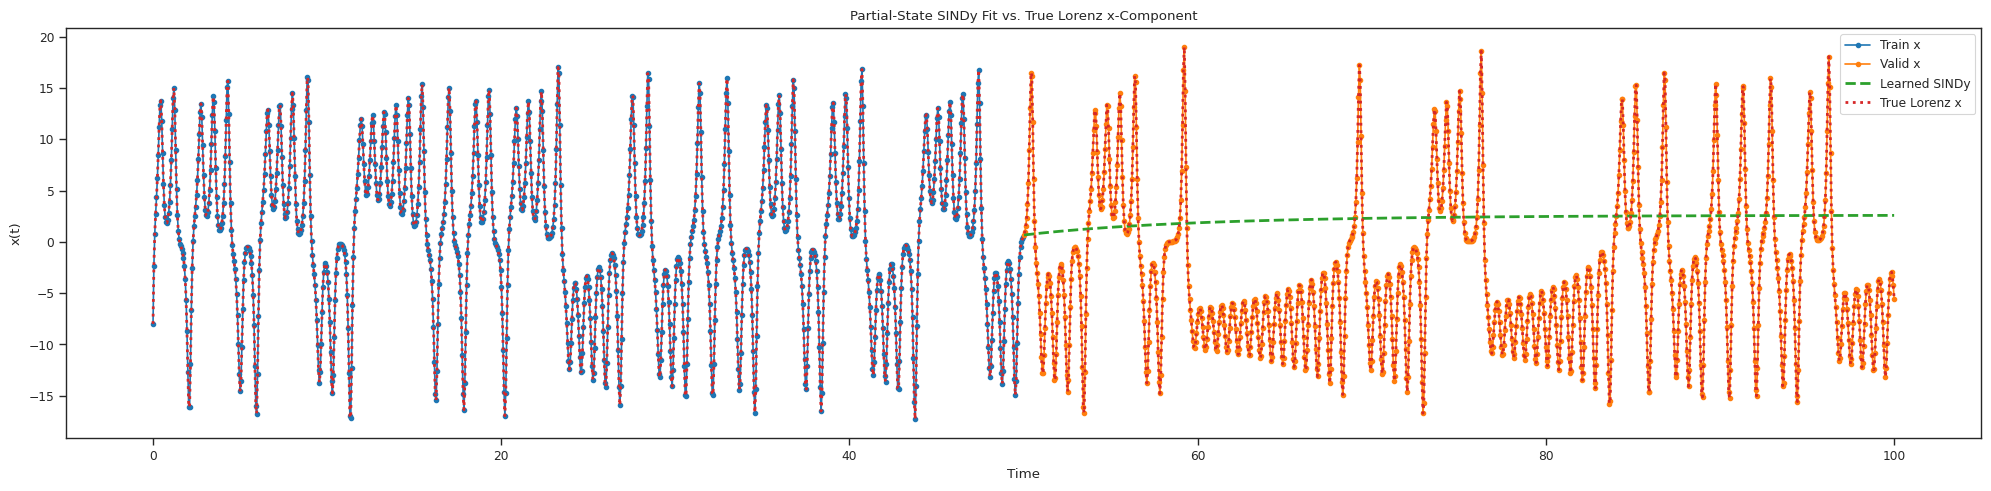

In [9]:
ts_train = ts[:split]
ts_val   = ts[split:]
x_true   = xs[:, 0]

plt.figure(figsize=(20, 5))

# training data
plt.plot(ts_train, x_train.flatten(),
         linestyle='-', marker='o', markersize=3, label='Train x')

# validation data
plt.plot(ts_val, x_val.flatten(),
         linestyle='-', marker='o', markersize=3, label='Valid x')

# learned SINDy model on validation
plt.plot(ts_val, xs_learned.flatten(),
         linestyle='--', linewidth=2, label='Learned SINDy')

# true Lorenz x‐component
plt.plot(ts, x_true,
         linestyle=':', linewidth=2, label='True Lorenz x')

plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Partial‐State SINDy Fit vs. True Lorenz x‐Component')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

## Part B - The Hankel Matrix

Part A failed because we tried to fit Markovian dynamics to a partially observed state.
There are no Markovian dynamics for partially observed states.
Partially observed states exhibit effective dynamics that appear to have memory (and noise).
The Hankel matrix is a way to create variables that account for memory.
We will try two variations.
First, we will just try to learn dynamics directly on the columns of the Hankel matrix.
This is not going to work if the memory we need is long.
Then, we will use SVD to reduce the dimensionality of the Hankel matrix before attempting to learn the dynamics.

Your data are $x(t_1),\dots,x(t_m)$.
The Hankel matrix is:

$$
\mathbf{H}_\ell = \begin{bmatrix}
x(t_1) & x(t_2) & x(t_3) & \dots x(t_{m-\ell})\\
x(t_2) & x(t_3) & x(t_4) & \dots x(t_{m-\ell+1})\\
\vdots & \vdots & \vdots & \dots \vdots\\
x(t_\ell) & x(t_{\ell+1}) & x(t_{\ell+3}) \dots & x(t_m)
\end{bmatrix}
$$

Write a function that forms the Hankel matrix given the data and $\ell$.

**Answer:**

In [10]:
def make_hankel(xs, ell):
    """Write a good docstring."""
    # write your code here
    # pass
    xs = np.asarray(xs)
    m = xs.shape[0]
    if not (1 <= ell <= m):
        raise ValueError(f"ell must be between 1 and {m}, got {ell}")

    n_cols = m - ell + 1
    H = np.empty((ell, n_cols), dtype=xs.dtype)
    for i in range(ell):
        H[i, :] = xs[i : i + n_cols]
    return H

## Part C - Apply SINDY on the Hankel matrix

Form the Hankel matrices for $x(t)$ and $\dot{x}(t)$ for $\ell=5$.
Try to represent the dynamics with a third degree polynomial.
Validate your results.
Do not expect this work very well.

**Answer:**
<br>
Ref of functions used here- https://predictivesciencelab.github.io/advanced-scientific-machine-learning/inverse/data/03_sindy_2.html

In [11]:
# as many code blocks and markdown blocks as you want

# Form Hankel matrices for x(t) and x˙(t) for l=5
l = 5

# Create Hankel matrices
H_x = make_hankel(partial_xs, l) # 5x1996
H_dx = make_hankel(partial_dxs, l) # 5x1996

ts_H = ts[l-1:] # 1996 (adjusted)

# Split for train and validation
n_cols     = H_x.shape[1] # 1996
split_cols = n_cols // 2 # 998

H_x_train = H_x[:, :split_cols] # 5x998
H_dx_train= H_dx[:, :split_cols] # 5x998
H_x_val   = H_x[:, split_cols:] # 5x998
H_dx_val  = H_dx[:, split_cols:] # 5x998
ts_val_H  = ts_H[split_cols:] # 998

# Reshape
x_train_H = H_x_train.T  # 998x5
dx_train_H= H_dx_train.T # 998x5
x_val_H   = H_x_val.T # 998x5
dx_val_H  = H_dx_val.T # 998x5


degree = 3 # As per the problem
# Apply polynomial features

poly_H = PolynomialFeatures(degree=degree)
Phi_train_H = poly_H.fit_transform(x_train_H) # 998x56

alpha = 1e-2
iter =1000

# Apply SINDY to learn dynamics
thetas_H = sparsify_dynamics(Phi_train_H, dx_train_H, alpha=alpha, max_iter=iter)

for j in range(thetas_H.shape[1]):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(poly_H.get_feature_names_out()):
        print(f"{name:10s} = {thetas_H[i][j]:.2f}")


# integrate over the validation time-grid

def f_learned_H(x, t, thetas, poly):
    phi = poly.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[:, j], phi)
    return dx

xs_learned = scipy.integrate.odeint(lambda x, t: f_learned_H(x, t, thetas_H, poly_H), x_val_H[0], ts_val_H)
# Compute MSE between the learned and true validation data
mse_H = np.mean((x_val_H.flatten() - xs_learned.flatten())**2)

# Print the MSE
print(f"Hankel‐SINDy validation MSE (l={l}, deg={degree}): {mse_H:.4e}")


Dynamics of x_1:
--------------------
1          = 0.00
x0         = -47.00
x1         = 102.99
x2         = -94.66
x3         = 48.25
x4         = -9.69
x0^2       = 0.00
x0 x1      = 0.00
x0 x2      = 0.00
x0 x3      = 0.00
x0 x4      = 0.00
x1^2       = 0.00
x1 x2      = 0.00
x1 x3      = 0.00
x1 x4      = 0.00
x2^2       = 0.00
x2 x3      = 0.00
x2 x4      = 0.00
x3^2       = 0.00
x3 x4      = 0.00
x4^2       = 0.00
x0^3       = 0.05
x0^2 x1    = -0.38
x0^2 x2    = 0.43
x0^2 x3    = -0.31
x0^2 x4    = 0.06
x0 x1^2    = 0.88
x0 x1 x2   = -1.58
x0 x1 x3   = 1.11
x0 x1 x4   = -0.13
x0 x2^2    = 0.72
x0 x2 x3   = -1.49
x0 x2 x4   = 0.36
x0 x3^2    = 0.68
x0 x3 x4   = -0.39
x0 x4^2    = 0.00
x1^3       = -1.27
x1^2 x2    = 4.38
x1^2 x3    = -2.72
x1^2 x4    = 0.33
x1 x2^2    = -6.05
x1 x2 x3   = 9.03
x1 x2 x4   = -1.92
x1 x3^2    = -3.44
x1 x3 x4   = 1.86
x1 x4^2    = -0.07
x2^3       = 2.62
x2^2 x3    = -5.68
x2^2 x4    = 0.93
x2 x3^2    = 4.04
x2 x3 x4   = -1.78
x2 x4^2    = 0.12
x3^3

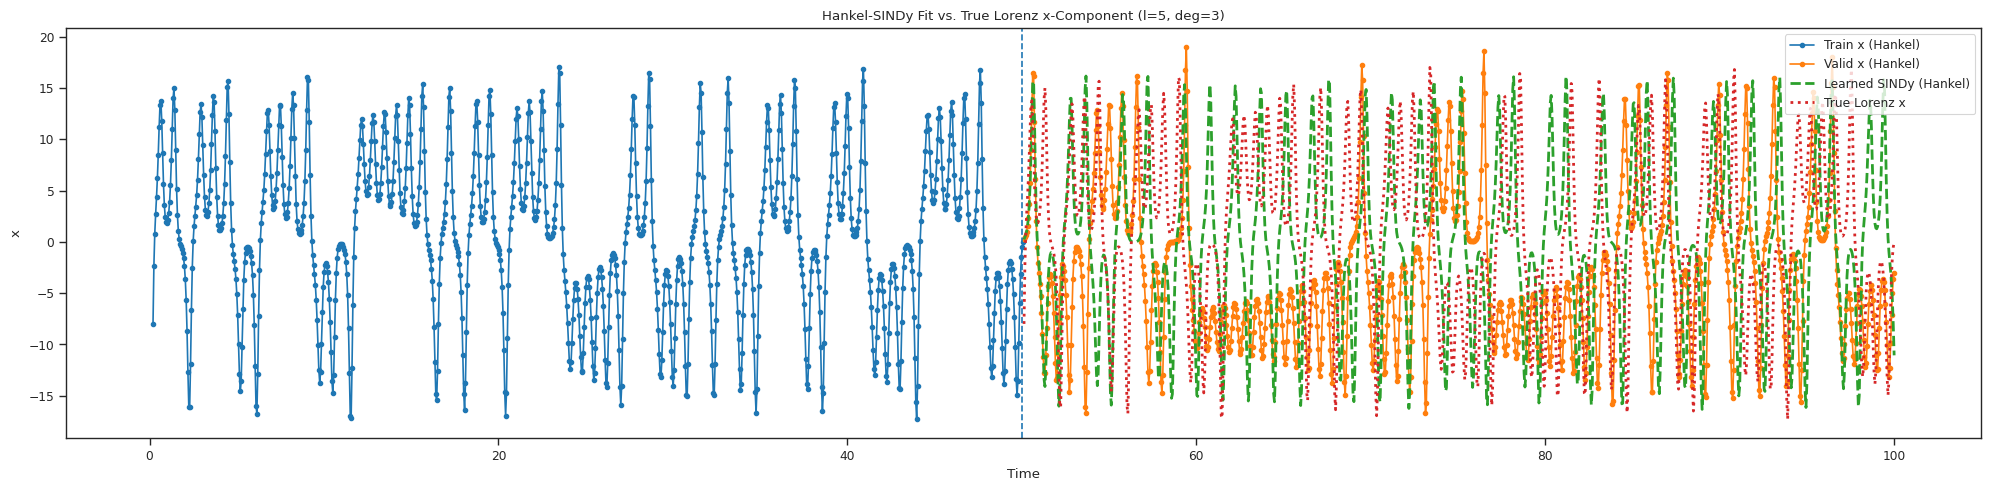

In [12]:
ts_train = ts_H[:split_cols]
ts_val   = ts_H[split_cols:]
x_true_aligned = x_true[:len(ts_val_H)]

plt.figure(figsize=(20, 5))

# Training data (first component of x_train_H)
plt.plot(ts_train, x_train_H[:, 0],
         linestyle='-', marker='o', markersize=3, label='Train x (Hankel)')

# Validation data (first component of x_val_H)
plt.plot(ts_val, x_val_H[:, 0],
         linestyle='-', marker='o', markersize=3, label='Valid x (Hankel)')

# Learned SINDy model on validation (first component)
plt.plot(ts_val, xs_learned[:, 0],
         linestyle='--', linewidth=2, label='Learned SINDy (Hankel)')

# True Lorenz x‐component
plt.plot(ts_val_H, x_true_aligned ,
         linestyle=':', linewidth=2, label='True Lorenz x')
plt.axvline(50, linestyle = "--")

plt.xlabel('Time')
plt.ylabel('x')
plt.title(f'Hankel-SINDy Fit vs. True Lorenz x-Component (l={l}, deg={degree})')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

## Part D - Do SVD on the Hankel matrix

Let's pick a big $\ell$. Say $\ell = 100$:
+ Form the corresponding Hankel matrix and then do SVD on it.
+ Plot the explained variance as a function of the number of singular values.
+ How much variance do you explain with three dimensions (this is the intrinsic dimensionality of the dynamical system)?
+ Visualize the first three POD modes.
+ Project the Hankel matrix columns to three dimensions (POD amplitudes/principal components).
+ Plot the time series of each one of the principal components.
+ Plot the 3D trajectory of the principal components.

**Answer:**

In [63]:
# as many code blocks and markdown blocks as you want

l = 100 # provided
# Form Hankel matrix
H_x = make_hankel(partial_xs, l) # 100x1901

# Perform SVD
U, S, Vt = np.linalg.svd(H_x, full_matrices=False) # Shape of S, 100

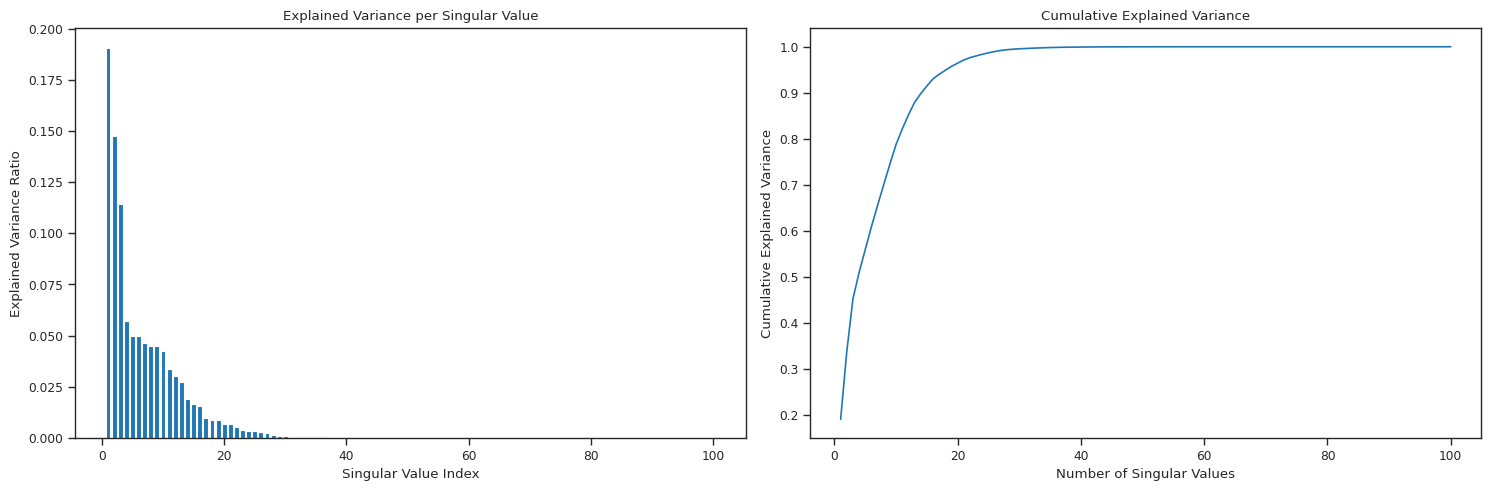

In [69]:
# Calculate the explained variance as the square of the singular values
total_variance = np.sum(S**2)
explained_variance = S**2 / total_variance

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, l + 1), explained_variance)
plt.xlabel('Singular Value Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance per Singular Value')

plt.subplot(1, 2, 2)
plt.plot(range(1, l + 1), cumulative_explained_variance)
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(False)
plt.tight_layout()

In [66]:
# # Variance explained by the first three dimensions
variance_explained_3d = cumulative_explained_variance[2]
print(f"Variance explained by the first 3 dimensions: {variance_explained_3d:.4f}")

Variance explained by the first 3 dimensions: 0.4525


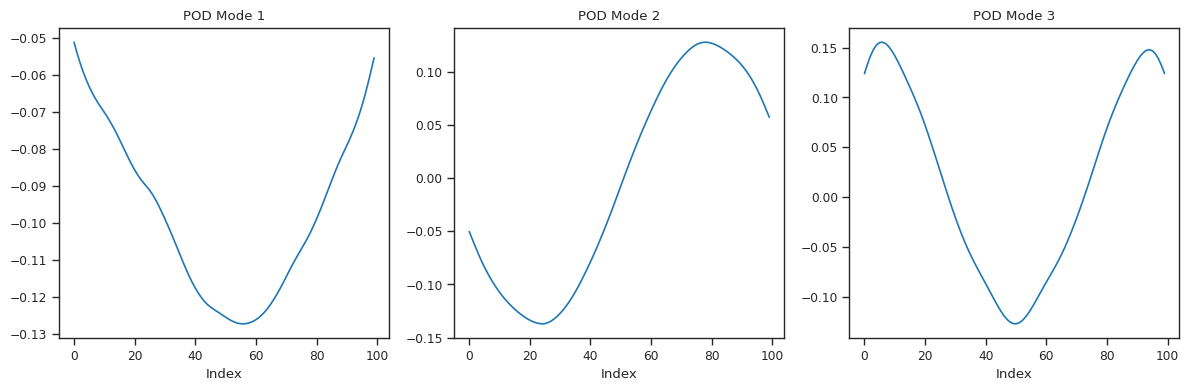

In [67]:
# Visualize first three POD modes
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(U[:, i])
    plt.title(f'POD Mode {i+1}')
    plt.xlabel('Index')
plt.tight_layout()

(100, 3)


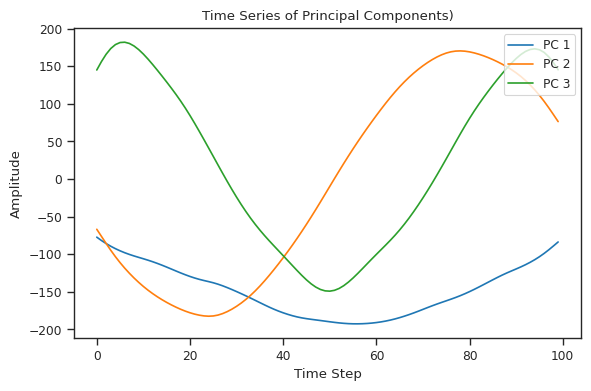

In [113]:
# Project Hankel matrix columns to three dimensions
pod_amplitudes = U[:, :3] @ np.diag(S[:3])
print(pod_amplitudes.shape)
plt.figure(figsize=(6, 4))

for i in range(3):
    plt.plot(pod_amplitudes[:, i], label=f'PC {i+1}')
plt.title('Time Series of Principal Components)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

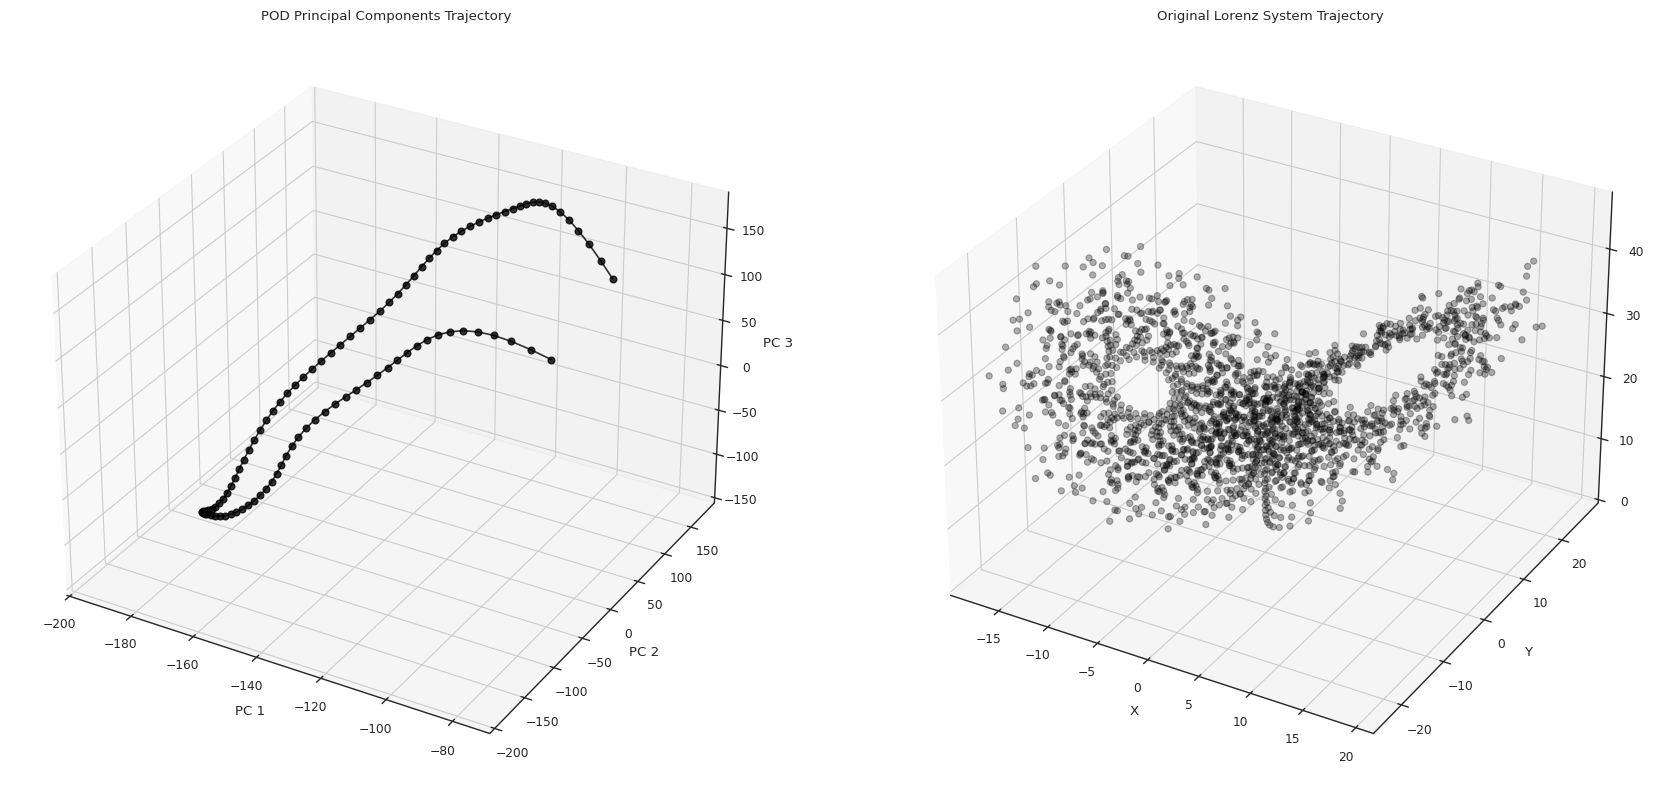

In [102]:
# Plot the 3D trajectory of the principal components.
fig = plt.figure(figsize=(18, 8))

# Left plotting POD principal components trajectory
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(pod_amplitudes[:, 0], pod_amplitudes[:, 1], pod_amplitudes[:, 2], color='black', marker='o', alpha =0.8)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_zlabel('PC 3')
ax1.set_title('POD Principal Components Trajectory')

# Right plotting original Lorenz system full trajectory
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(xs[:, 0], xs[:, 1], xs[:, 2], color='black', marker='o', alpha = 0.3)  # Use scatter plot with dots
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Original Lorenz System Trajectory')
plt.tight_layout()
plt.show()

## Part E - Find the time derivatives of the principal components of the Hankel matrix

To do SINDY, we need to have time derivatives.
So, you have to find the time derivatives of the principal components of the Hankel matrix.
You have two options:
+ Work out analytically how the observed `partial_dxs` will project on the POD modes, or;
+ Use numerical differentiation to find the required time derivatives (Google around for the best Python library for numerical differentiation). In this case, simple finite differences should work.

**Answer:**

(3, 1901)


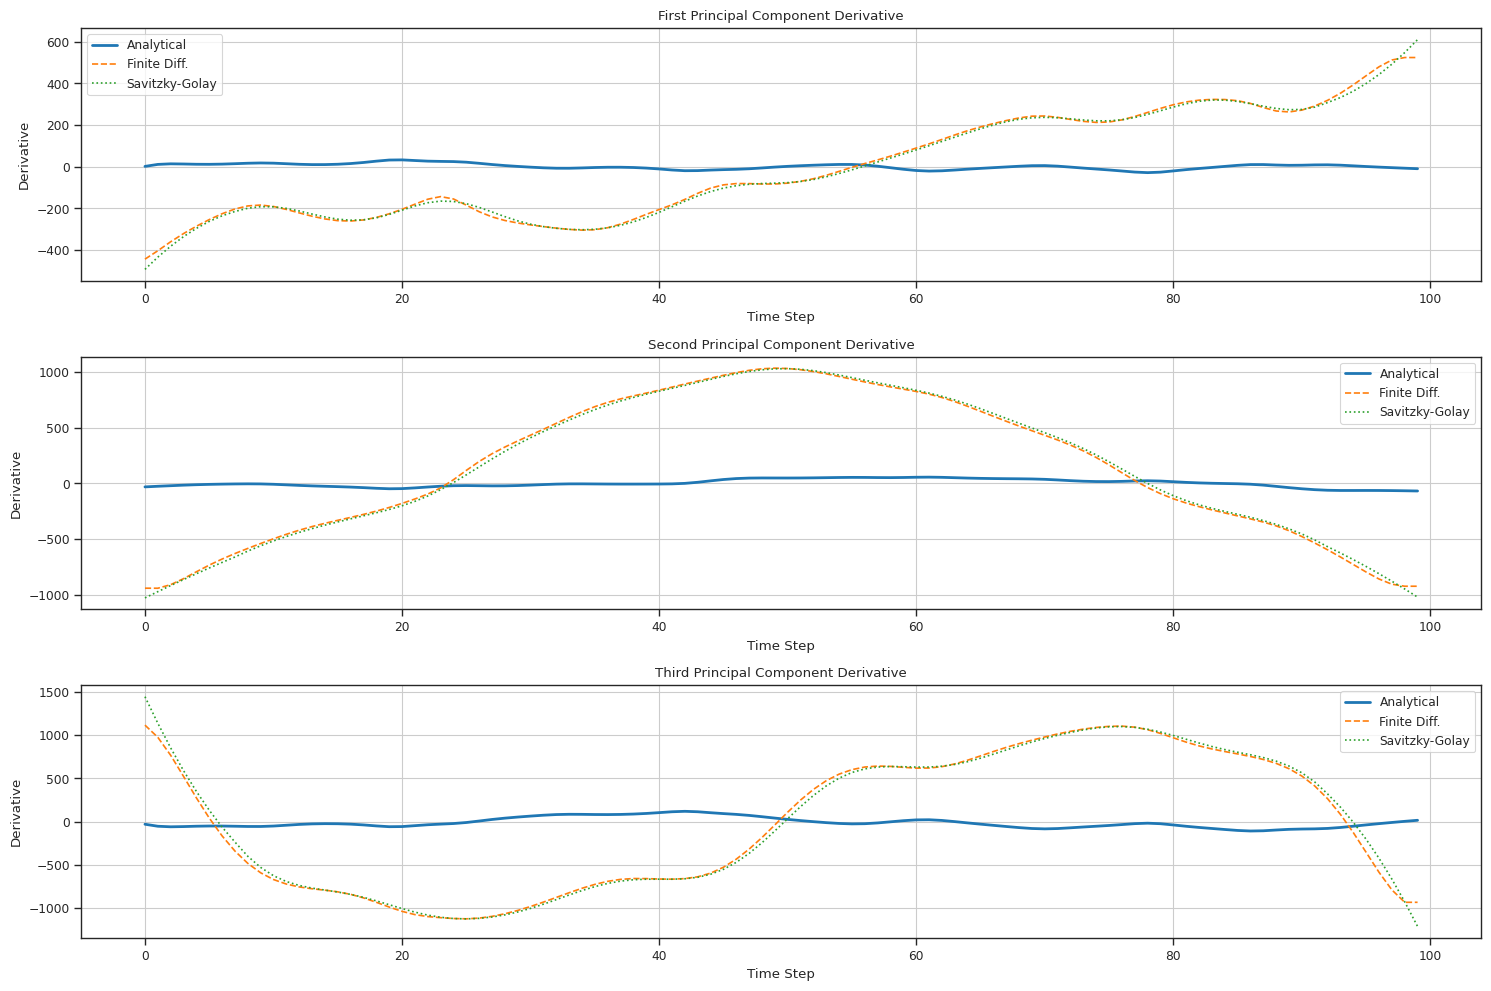

Correlation between analytical and numerical methods:
Component 1:
  - Simple finite differences: -0.3640
  - Savitzky-Golay filter: -0.3613
Component 2:
  - Simple finite differences: 0.7706
  - Savitzky-Golay filter: 0.7786
Component 3:
  - Simple finite differences: -0.5036
  - Savitzky-Golay filter: -0.5262


In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy import signal
# Ask is to find the time derivatives of the principal components of the Hankel
# matrix using two options

# Option1: Analytical approach
# Create a Hankel matrix from the derivatives (previously created)
H_dx = make_hankel(partial_dxs, l)

# Project the derivative Hankel matrix onto the POD modes as instruction
pod_derivatives_analytical = U.T @ H_dx

# Extract the first 3 components for SINDy
pod_derivatives_analytical_3d = pod_derivatives_analytical[:3, :]
print(pod_derivatives_analytical_3d.shape)

# Option 2: Numerical differentiation
pod_amplitudes = U[:, :3] @ np.diag(s[:3]) # Copy from part D

# First: Simple finite differences
dt = 0.01  # time step from the original simulation
pod_derivatives_numerical_simple = np.zeros_like(pod_amplitudes)

# Forward differences for most points
pod_derivatives_numerical_simple[:-1] = (pod_amplitudes[1:] - pod_amplitudes[:-1]) / dt
# For the last point, use backward difference
pod_derivatives_numerical_simple[-1] = (pod_amplitudes[-1] - pod_amplitudes[-2]) / dt

# Alternative: Using scipy's savgol_filter for smoothed derivatives
window_length = 15
poly_order = 3
pod_derivatives_savgol = np.zeros_like(pod_amplitudes)

for i in range(3):
    pod_derivatives_savgol[:, i] = signal.savgol_filter(
        pod_amplitudes[:, i], window_length, poly_order, deriv=1, delta=dt
    )

# Plot and compare the different derivatives
plt.figure(figsize=(15, 10))
components = ['First', 'Second', 'Third']
methods = ['Analytical', 'Finite Diff.', 'Savitzky-Golay']

for i in range(3):
    plt.subplot(3, 1, i+1)

    # Extract derivatives from the analytical approach (transpose to match dimensions)
    analytical = pod_derivatives_analytical[i, :l]

    # Plot all methods
    plt.plot(analytical, label=methods[0], linewidth=2)
    plt.plot(pod_derivatives_numerical_simple[:l, i], label=methods[1], linestyle='--')
    plt.plot(pod_derivatives_savgol[:l, i], label=methods[2], linestyle=':')

    plt.title(f'{components[i]} Principal Component Derivative')
    plt.xlabel('Time Step')
    plt.ylabel('Derivative')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate the correlation between analytical and numerical methods
print("Correlation between analytical and numerical methods:")
for i in range(3):
    analytical = pod_derivatives_analytical[i, :l]
    corr_simple = np.corrcoef(analytical, pod_derivatives_numerical_simple[:l, i])[0, 1]
    corr_savgol = np.corrcoef(analytical, pod_derivatives_savgol[:l, i])[0, 1]

    print(f"Component {i+1}:")
    print(f"  - Simple finite differences: {corr_simple:.4f}")
    print(f"  - Savitzky-Golay filter: {corr_savgol:.4f}")

## Part F - Do SINDY on the principal components of the Hankel matrix

You are now ready to do SINDY on the principal components of the Hankel matrix.
Use a polynomial of degree 5 as the right-hand-side.
Try to validate your results.

**Answer:**

In [ ]:
# as many code blocks and markdown blocks as you want



# Problem 2 - SINDY with measurement noise and no derivatives

Let's get back to the Lorenz system. This time, we are going to assume that we have access to the full state, but we do not have the derivative, and the measurements are corrupted by noise.
So, your available data are:

In [ ]:
eta = 0.01
noisy_x = xs + eta * np.random.normal(0, 1.0, xs.shape)

Review the package [derivative](https://pypi.org/project/derivative/) (which part of the `pysindy` ecosystem) and:
- Use a suitable method to estimate the derivative dx/dt from the noisy data `noisy_xs`.
- Apply SINDY to the denoised data and the numerical derivatives.
- Validate your results.

**Answer:**

# Problem 3 - Physics-informed Neural Networks for Solving a Neo-Hookean Hyperelasticity Problem

*The original version of this problem was developed by Atharva Hans as a companion to [this](https://youtu.be/o9JaZGWekWQ).

Consider a neo-Hookean square body defined on $(x,y) \in [0,1]^2$. Let $\mathbf{u}(x,y) = (u_1, u_2)$ describe the displacement field for this body.
This body is subjected to the following displacement boundary conditions:

$$
u_1(0,y) = 0,
$$

$$
u_2(0,y) = 0,
$$

$$
u_1(1,y) = \delta,
$$

$$
u_2(1,y) = 0,
$$

with $\delta$ referring to the applied displacement along the x-direction.

For this hyperelastic material, the stored energy $E_b$ in the body can be expressed in as:

$$
E_b[\mathbf{u}(\cdot)] = \int_{[0,1]^2}\left\{\frac{1}{2}(\sum_{i=1}^2\sum_{j=1}^2{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy,
$$

with

$$
\mathbf{F} = \mathbf{I} + \nabla \mathbf{u},
$$

where $\mathbf{I}$ is an identity matrix.

The final orientation of this body is described by a displacement field that minimizes the stored energy $E_b$.
The idea is to use a neural network to approximate the displacement field and train it by minimizing the stored energy $E_b$.

To automatically satisfy the boundary conditions, we will use this approximation:
$$
u_1(x,y) = \delta - \delta(1-x) + x(1-x)N_1(x,y;\theta),
$$
and,
$$
u_2(x,y) = x(1-x)N_2(x,y;\theta)
$$
where $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$ are neural networks.

## Part A

Solve the problem above for $\delta=0.1$ using a physics-informed neural network (PINN).
Use separate neural networks for $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$.
Start with a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations.
Add a Fourier feature layer at the beginning of the network.
Feel free to change the architecture if you think it is necessary.

Use `equinox` for the neural networks and `optax` for the optimization.
Use a sampling average of 32 collocation points to compute the integral of the stored energy.
Use the Adam optimizer with a learning rate of 0.001 for 1000 iterations to debug.
Feel free to play with the learning rate, the number of collocation points, and the number of iterations.

Show the evolution of the loss function over the iterations.
Plot the final displacement field (plot $u_1(x,y)$ and $u_2(x,y)$ separately).

*Put your answer here. Use as many markdown and code blocks as you want.*

In [ ]:
# your code here

## Part B

Solve the problem for $\delta=0.5$ using the same architecture as above.
It will likely fail to train.
If yes, then use the solution of $\delta=0.1$ as the initial guess for $\delta=0.2$, and then use the solution of $\delta=0.2$ as the initial guess for $\delta=0.3$, and so on, until you reach $\delta=0.5$.
This is called transfer learning.

At the end, plot the final displacement field for $\delta=0.5$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [ ]:
# your code here

## Part C

Solve the parametric problem for $\delta \in [0,0.5]$. That is, build a neural network that takes $\delta$ as input and outputs the displacement field. To do this:
+ Modify the loss function to:

$$
\mathcal{L} = \int_0^{0.5} \int_{[0,1]^2} \left\{\frac{1}{2}(\sum_{i}\sum_{j}{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy d\delta.
$$

+ Modify the neural networks to take $\delta$ as input, say $N_1(x,y;\delta;\theta)$ and $N_2(x,y;\delta;\theta)$. Your field will be $\mathbf{u}(x,y;\delta;\theta)$.
Use the following architecture for the neural networks:

$$
N_1(x,y;\delta) = \sum_{i=1}^n b_{1,i}(\delta)t_{1,i}(x,y).
$$

Here, $n$ is your choice (start with $n=10$), $b_{1,i}$ is a neural network that takes $\delta$ as input and outputs a scalar, and $t_{1,i}(x,y)$ is a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations, and Fourier features at the beginning. The same applies to $N_2(x,y;\delta)$. This representation resembles an expansion in terms of basis functions.
The same architecture appears in DeepONet.

Plot the $x$ and $y$ displacement at $x=0.5, y=0.5$ as a function of $\delta$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [ ]:
# your code here